### Importing data and libraries

In [39]:
import os
import numpy as np
import pandas as pd

import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Embedding, Input, Activation, Masking
from tensorflow.python.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import optimizers, initializers, layers

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
df = pd.read_csv('data/sentiment_data.csv')
df.shape

(1952, 17)

In [55]:
# Apply one hot encoding
one_hot = pd.get_dummies(df['topic'])
df = df.drop('topic',axis = 1)
df = df.join(one_hot)
df.head()

,Unnamed: 0,Unnamed: 0.1,title,score,id,subreddit,url,num_comments,body,created,reddit_punct,reddit_tokenized,reddit_nonstop,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,anxiety,depression
0,0,0,Let your light shine!,19,qc0aqd,Anxiety,https://www.reddit.com/r/Anxiety/comments/qc0a...,25,congrats r anxiety we ve all made it to wedne...,1.634735e+09,congrats ranxiety weve all made it to wednesda...,"['congrats', 'ranxiety', 'weve', 'all', 'made'...","['congrats', 'ranxiety', 'weve', 'made', 'wedn...",0.480967,2.230880e-01,Positive,1,0
1,1,1,Looking for new mods! (subreddit and Discord),11,qb0ort,Anxiety,https://www.reddit.com/r/Anxiety/comments/qb0o...,0,with both the subreddit and discord continuing...,1.634606e+09,with both the subreddit and discord continuing...,"['with', 'both', 'the', 'subreddit', 'and', 'd...","['subreddit', 'discord', 'continuing', 'grow',...",0.455455,3.295455e-03,Positive,1,0
2,2,2,fuck,409,qe7rl0,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe7r...,47,i went to get my haircut and the person cuttin...,1.635005e+09,i went to get my haircut and the person cuttin...,"['i', 'went', 'to', 'get', 'my', 'haircut', 'a...","['went', 'get', 'haircut', 'person', 'cutting'...",0.400183,-8.475275e-02,Negative,1,0
3,3,3,Does anyone else feel bad for inanimate objects?,143,qeecds,Anxiety,https://www.reddit.com/r/Anxiety/comments/qeec...,27,for example i feel bad for a snowblower that ...,1.635026e+09,for example i feel bad for a snowblower that m...,"['for', 'example', 'i', 'feel', 'bad', 'for', ...","['example', 'feel', 'bad', 'snowblower', 'pare...",0.463889,3.700743e-17,Positive,1,0
4,4,4,Does anybody have like a week of no anxiety th...,248,qe3u9l,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe3u...,26,i swear i have been in a cycle of going i ve ...,1.634992e+09,i swear i have been in a cycle of going i ve ...,"['i', 'swear', 'i', 'have', 'been', 'in', 'a',...","['swear', 'cycle', 'going', 'never', 'felt', '...",0.750000,-2.500000e-01,Negative,1,0


In [56]:
train = df.head(1600)
test = df.tail(352)

In [57]:
print('Train shape: ' + str(train.shape))
print('Test shape: ' + str(test.shape))

Train shape: (1600, 18)
Test shape: (352, 18)


### Data Exploration and Analysis

In [58]:
train.head()

,Unnamed: 0,Unnamed: 0.1,title,score,id,subreddit,url,num_comments,body,created,reddit_punct,reddit_tokenized,reddit_nonstop,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,anxiety,depression
0,0,0,Let your light shine!,19,qc0aqd,Anxiety,https://www.reddit.com/r/Anxiety/comments/qc0a...,25,congrats r anxiety we ve all made it to wedne...,1.634735e+09,congrats ranxiety weve all made it to wednesda...,"['congrats', 'ranxiety', 'weve', 'all', 'made'...","['congrats', 'ranxiety', 'weve', 'made', 'wedn...",0.480967,2.230880e-01,Positive,1,0
1,1,1,Looking for new mods! (subreddit and Discord),11,qb0ort,Anxiety,https://www.reddit.com/r/Anxiety/comments/qb0o...,0,with both the subreddit and discord continuing...,1.634606e+09,with both the subreddit and discord continuing...,"['with', 'both', 'the', 'subreddit', 'and', 'd...","['subreddit', 'discord', 'continuing', 'grow',...",0.455455,3.295455e-03,Positive,1,0
2,2,2,fuck,409,qe7rl0,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe7r...,47,i went to get my haircut and the person cuttin...,1.635005e+09,i went to get my haircut and the person cuttin...,"['i', 'went', 'to', 'get', 'my', 'haircut', 'a...","['went', 'get', 'haircut', 'person', 'cutting'...",0.400183,-8.475275e-02,Negative,1,0
3,3,3,Does anyone else feel bad for inanimate objects?,143,qeecds,Anxiety,https://www.reddit.com/r/Anxiety/comments/qeec...,27,for example i feel bad for a snowblower that ...,1.635026e+09,for example i feel bad for a snowblower that m...,"['for', 'example', 'i', 'feel', 'bad', 'for', ...","['example', 'feel', 'bad', 'snowblower', 'pare...",0.463889,3.700743e-17,Positive,1,0
4,4,4,Does anybody have like a week of no anxiety th...,248,qe3u9l,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe3u...,26,i swear i have been in a cycle of going i ve ...,1.634992e+09,i swear i have been in a cycle of going i ve ...,"['i', 'swear', 'i', 'have', 'been', 'in', 'a',...","['swear', 'cycle', 'going', 'never', 'felt', '...",0.750000,-2.500000e-01,Negative,1,0


In [59]:
test.head()

,Unnamed: 0,Unnamed: 0.1,title,score,id,subreddit,url,num_comments,body,created,reddit_punct,reddit_tokenized,reddit_nonstop,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,anxiety,depression
1600,1600,1630,Depression and sexual dysfunction,4,qdo651,depression,https://www.reddit.com/r/depression/comments/q...,2,hi i need help i ve been experiencing severe...,1.634930e+09,hi i need help i ve been experiencing severe d...,"['hi', 'i', 'need', 'help', 'i', 've', 'been',...","['hi', 'need', 'help', 'experiencing', 'severe...",0.441667,0.115000,Positive,0,1
1601,1601,1631,Question,3,qdpxuf,depression,https://www.reddit.com/r/depression/comments/q...,4,i thought i can fight my mental illness but to...,1.634936e+09,i thought i can fight my mental illness but to...,"['i', 'thought', 'i', 'can', 'fight', 'my', 'm...","['thought', 'fight', 'mental', 'illness', 'tod...",0.665000,-0.085000,Negative,0,1
1602,1602,1632,How do people do it?,7,qdmjbt,depression,https://www.reddit.com/r/depression/comments/q...,1,i m sitting at work depressed and tired i onl...,1.634926e+09,im sitting at work depressed and tired i only ...,"['im', 'sitting', 'at', 'work', 'depressed', '...","['im', 'sitting', 'work', 'depressed', 'tired'...",0.629167,-0.040741,Negative,0,1
1603,1603,1633,I wish I was white,13,qdgln6,depression,https://www.reddit.com/r/depression/comments/q...,10,i m an asian male and there s not a single day...,1.634908e+09,im an asian male and theres not a single day w...,"['im', 'an', 'asian', 'male', 'and', 'theres',...","['im', 'asian', 'male', 'theres', 'single', 'd...",0.382468,-0.106331,Negative,0,1
1604,1604,1634,Suicidal thoughts but I know I don’t want to die…,3,qdproa,depression,https://www.reddit.com/r/depression/comments/q...,0,i was just wondering if anyone else gets this ...,1.634935e+09,i was just wondering if anyone else gets this ...,"['i', 'was', 'just', 'wondering', 'if', 'anyon...","['wondering', 'anyone', 'else', 'gets', 'like'...",0.341667,0.100000,Positive,0,1


In [60]:
train.describe()

,Unnamed: 0,Unnamed: 0.1,score,num_comments,created,TextBlob_Subjectivity,TextBlob_Polarity,anxiety,depression
count,1600.00000,1600.000000,1600.000000,1600.000000,1.600000e+03,1600.000000,1600.000000,1600.000000,1600.000000
mean,799.50000,819.353750,12.035000,3.864375,1.634861e+09,0.507374,-0.009008,0.606250,0.393750
std,462.02453,472.592578,84.918016,16.014564,1.571584e+06,0.166718,0.180912,0.488733,0.488733
min,0.00000,0.000000,0.000000,0.000000,1.572361e+09,0.000000,-1.000000,0.000000,0.000000
25%,399.75000,407.750000,1.000000,0.000000,1.634787e+09,0.436359,-0.096262,0.000000,0.000000
50%,799.50000,824.500000,2.000000,1.000000,1.634946e+09,0.511466,0.000000,1.000000,0.000000
75%,1199.25000,1229.250000,3.000000,3.000000,1.635017e+09,0.597569,0.087500,1.000000,1.000000
max,1599.00000,1629.000000,2363.000000,433.000000,1.635067e+09,1.000000,0.850000,1.000000,1.000000


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1600 non-null   int64  
 1   Unnamed: 0.1           1600 non-null   int64  
 2   title                  1600 non-null   object 
 3   score                  1600 non-null   int64  
 4   id                     1600 non-null   object 
 5   subreddit              1600 non-null   object 
 6   url                    1600 non-null   object 
 7   num_comments           1600 non-null   int64  
 8   body                   1600 non-null   object 
 9   created                1600 non-null   float64
 10  reddit_punct           1600 non-null   object 
 11  reddit_tokenized       1600 non-null   object 
 12  reddit_nonstop         1600 non-null   object 
 13  TextBlob_Subjectivity  1600 non-null   float64
 14  TextBlob_Polarity      1600 non-null   float64
 15  Text

### Cleaning the Dataset

In [62]:
review = train['body'].loc[0]
review

'congrats  r anxiety we ve all made it to wednesday this is a weekly thread that serves as a place for us to shine some light on what is going well in our lives  it is easy for mental health subreddits to focus primarily on the negative  after all we re not here because everything is going wonderfully but  once in a while you get shown the light in the strangest of places if you look at it right  so whether you made it out of bed today  spoke up in a meeting or class  rode the bus  or just stepped outside please share with us what went well for you in the past week any accomplishment  victory  positive thought or action no matter how big or small is welcome here '

In [63]:
def clean_text(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\[[^]]*\]', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    return text

In [64]:
train['body'] = train['body'].apply(lambda x: clean_text(x))
train.head()

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Unnamed: 0.1,title,score,id,subreddit,url,num_comments,body,created,reddit_punct,reddit_tokenized,reddit_nonstop,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,anxiety,depression
0,0,0,Let your light shine!,19,qc0aqd,Anxiety,https://www.reddit.com/r/Anxiety/comments/qc0a...,25,congrats r anxiety we ve all made it to wedne...,1.634735e+09,congrats ranxiety weve all made it to wednesda...,"['congrats', 'ranxiety', 'weve', 'all', 'made'...","['congrats', 'ranxiety', 'weve', 'made', 'wedn...",0.480967,2.230880e-01,Positive,1,0
1,1,1,Looking for new mods! (subreddit and Discord),11,qb0ort,Anxiety,https://www.reddit.com/r/Anxiety/comments/qb0o...,0,with both the subreddit and discord continuing...,1.634606e+09,with both the subreddit and discord continuing...,"['with', 'both', 'the', 'subreddit', 'and', 'd...","['subreddit', 'discord', 'continuing', 'grow',...",0.455455,3.295455e-03,Positive,1,0
2,2,2,fuck,409,qe7rl0,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe7r...,47,i went to get my haircut and the person cuttin...,1.635005e+09,i went to get my haircut and the person cuttin...,"['i', 'went', 'to', 'get', 'my', 'haircut', 'a...","['went', 'get', 'haircut', 'person', 'cutting'...",0.400183,-8.475275e-02,Negative,1,0
3,3,3,Does anyone else feel bad for inanimate objects?,143,qeecds,Anxiety,https://www.reddit.com/r/Anxiety/comments/qeec...,27,for example i feel bad for a snowblower that ...,1.635026e+09,for example i feel bad for a snowblower that m...,"['for', 'example', 'i', 'feel', 'bad', 'for', ...","['example', 'feel', 'bad', 'snowblower', 'pare...",0.463889,3.700743e-17,Positive,1,0
4,4,4,Does anybody have like a week of no anxiety th...,248,qe3u9l,Anxiety,https://www.reddit.com/r/Anxiety/comments/qe3u...,26,i swear i have been in a cycle of going i ve ...,1.634992e+09,i swear i have been in a cycle of going i ve ...,"['i', 'swear', 'i', 'have', 'been', 'in', 'a',...","['swear', 'cycle', 'going', 'never', 'felt', '...",0.750000,-2.500000e-01,Negative,1,0


In [65]:
test['body'] = test['body'].apply(lambda x: clean_text(x))
test.head()

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,Unnamed: 0.1,title,score,id,subreddit,url,num_comments,body,created,reddit_punct,reddit_tokenized,reddit_nonstop,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,anxiety,depression
1600,1600,1630,Depression and sexual dysfunction,4,qdo651,depression,https://www.reddit.com/r/depression/comments/q...,2,hi i need help i ve been experiencing severe...,1.634930e+09,hi i need help i ve been experiencing severe d...,"['hi', 'i', 'need', 'help', 'i', 've', 'been',...","['hi', 'need', 'help', 'experiencing', 'severe...",0.441667,0.115000,Positive,0,1
1601,1601,1631,Question,3,qdpxuf,depression,https://www.reddit.com/r/depression/comments/q...,4,i thought i can fight my mental illness but to...,1.634936e+09,i thought i can fight my mental illness but to...,"['i', 'thought', 'i', 'can', 'fight', 'my', 'm...","['thought', 'fight', 'mental', 'illness', 'tod...",0.665000,-0.085000,Negative,0,1
1602,1602,1632,How do people do it?,7,qdmjbt,depression,https://www.reddit.com/r/depression/comments/q...,1,i m sitting at work depressed and tired i onl...,1.634926e+09,im sitting at work depressed and tired i only ...,"['im', 'sitting', 'at', 'work', 'depressed', '...","['im', 'sitting', 'work', 'depressed', 'tired'...",0.629167,-0.040741,Negative,0,1
1603,1603,1633,I wish I was white,13,qdgln6,depression,https://www.reddit.com/r/depression/comments/q...,10,i m an asian male and there s not a single day...,1.634908e+09,im an asian male and theres not a single day w...,"['im', 'an', 'asian', 'male', 'and', 'theres',...","['im', 'asian', 'male', 'theres', 'single', 'd...",0.382468,-0.106331,Negative,0,1
1604,1604,1634,Suicidal thoughts but I know I don’t want to die…,3,qdproa,depression,https://www.reddit.com/r/depression/comments/q...,0,i was just wondering if anyone else gets this ...,1.634935e+09,i was just wondering if anyone else gets this ...,"['i', 'was', 'just', 'wondering', 'if', 'anyon...","['wondering', 'anyone', 'else', 'gets', 'like'...",0.341667,0.100000,Positive,0,1


In [66]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sparshbohra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(10000000)

10000000


In [68]:
train['body'] = train['body'].apply(lambda x: clean_text(x))
test['body'] = test['body'].apply(lambda x: clean_text(x))
train.to_csv('clean_train_final.csv')
test.to_csv('clean_test_final.csv')

/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/sparshbohra/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
train_df = train['body']
test_df = test['body']

### LSTM

Steps for the Model:
- Tokenize
- Pad
- Create Model
- Fit the Model
- Evaluate

In [80]:
max_features = 20000
maxlen = 200
tokenizer = Tokenizer(num_words = max_features)

In [81]:
# Tokenize

tokenizer.fit_on_texts(train_df)
X_train_token = tokenizer.texts_to_sequences(train_df)

tokenizer.fit_on_texts(test_df)
X_test_token = tokenizer.texts_to_sequences(test_df)

In [82]:
# Pad

X_train = pad_sequences(X_train_token, maxlen = maxlen, padding = 'post')
X_test  = pad_sequences(X_test_token, maxlen = maxlen, padding = 'post')
print(X_train.shape, X_test.shape)

(1600, 200) (352, 200)


In [83]:
cols = ['anxiety','depression']
targets = train[cols].values

In [84]:
# Create the Model

model = Sequential([Input(shape=(maxlen, )),
                    Embedding(max_features, 128, mask_zero = True),
                    LSTM(64, return_sequences = True, dropout = 0.2),
                    GlobalMaxPool1D(),
                    Dropout(0.2),
                    Dense(64, activation = 'relu'),
                    Dropout(0.2),
                    Dense(2, activation = 'softmax')])

In [85]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 64)           49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [87]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

monitor = EarlyStopping(monitor = 'val_loss', 
                        min_delta = 1e-3, 
                        patience = 5, verbose = 1, 
                        restore_best_weights = True)

history = model.fit(X_train, targets,
                    batch_size = 32,
                    epochs = 10, validation_split = 0.1,
                    callbacks = [monitor])

Train on 1440 samples, validate on 160 samples
Epoch 1/10
1440/1440 [==============================] - 16s 11ms/sample - loss: 0.6397 - accuracy: 0.6708 - val_loss: 1.0289 - val_accuracy: 0.0000e+00
Epoch 2/10
1440/1440 [==============================] - 13s 9ms/sample - loss: 0.5567 - accuracy: 0.6757 - val_loss: 0.8400 - val_accuracy: 0.1500
Epoch 3/10
1440/1440 [==============================] - 12s 9ms/sample - loss: 0.3864 - accuracy: 0.8215 - val_loss: 0.7425 - val_accuracy: 0.7063
Epoch 4/10
1440/1440 [==============================] - 12s 9ms/sample - loss: 0.2120 - accuracy: 0.9319 - val_loss: 0.8442 - val_accuracy: 0.6500
Epoch 5/10
1440/1440 [==============================] - 12s 9ms/sample - loss: 0.1106 - accuracy: 0.9632 - val_loss: 1.0665 - val_accuracy: 0.6562
Epoch 6/10
1440/1440 [==============================] - 12s 9ms/sample - loss: 0.0677 - accuracy: 0.9778 - val_loss: 0.6821 - val_accuracy: 0.7563
Epoch 7/10
1440/1440 [==============================] - 12s 8ms/sa

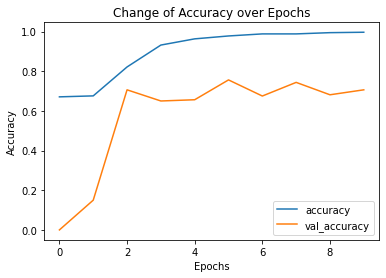

In [88]:
# Evaluate

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], '')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.title('Change of Accuracy over Epochs')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

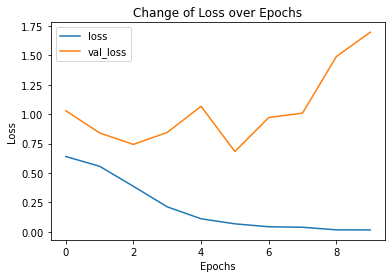

In [89]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], '')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.title('Change of Loss over Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

### Prediction on test data

In [90]:
prediction = model.predict(X_test)
prediction

array([[9.90017235e-01, 9.98276006e-03],
       [9.98513877e-01, 1.48615043e-03],
       [9.99999881e-01, 8.35797564e-08],
       [9.39504266e-01, 6.04957603e-02],
       [6.10652626e-01, 3.89347345e-01],
       [2.52739614e-04, 9.99747217e-01],
       [6.27441751e-03, 9.93725598e-01],
       [9.52126980e-01, 4.78730723e-02],
       [9.99980927e-01, 1.90425508e-05],
       [4.02566910e-01, 5.97433090e-01],
       [1.33178905e-02, 9.86682177e-01],
       [9.99942064e-01, 5.78924046e-05],
       [9.99993205e-01, 6.77975595e-06],
       [7.20496893e-01, 2.79503107e-01],
       [9.99985814e-01, 1.41352557e-05],
       [7.04450011e-01, 2.95550048e-01],
       [1.20472245e-01, 8.79527688e-01],
       [9.99730885e-01, 2.69046839e-04],
       [9.99999285e-01, 7.04386821e-07],
       [9.99998212e-01, 1.84740838e-06],
       [1.76622272e-02, 9.82337832e-01],
       [1.22740846e-02, 9.87725914e-01],
       [3.32171470e-02, 9.66782928e-01],
       [1.40317939e-02, 9.85968232e-01],
       [9.998686

In [93]:
import json
from tensorflow.keras.models import model_from_json, load_model

model.save('hackduke.h5')

# Save Weights + Architecture
model.save_weights('hackduke.h5')
with open('hackduke.json', 'w') as f:
    f.write(model.to_json())

In [121]:
from tensorflow.keras.models import load_model
model.save('hDModel.h5')

### Test on custom data

In [94]:
!pip install 'tensorflow==2.4.1'
!pip install 'keras==2.4.0'

  Using cached tensorflow-2.4.1-cp37-cp37m-macosx_10_11_x86_64.whl (173.9 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
     |████████████████████████████████| 5.8 MB 2.8 MB/s eta 0:00:01     |███████████████████████▎        | 4.2 MB 2.8 MB/s eta 0:00:01
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfu

In [119]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("hackDukeModel.h5")
print("Loaded model from disk")

Loaded model from disk


In [123]:
model = load_model('hDModel.h5')

In [124]:
from tensorflow import keras
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
import numpy as np

In [125]:
CLASSES = ['anxiety','depression']

In [126]:
def clean_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\[[^]]*\]', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    tokenizer = TreebankWordTokenizer()
    comment_tokens = tokenizer.tokenize(text)
    return comment_tokens

def remove_stopwords(text):
    stemmer=PorterStemmer()
    words=[]

    for word in text:
        if(word not in stopwords.words('english')):
            stem_word=stemmer.stem(word)
            words.append(stem_word)
    return words

def output_prediction(text, max_features = 22000, maxlen = 200):
    tokenizer=Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(text)
    tokenized_train=tokenizer.texts_to_sequences(text)
    x_train=pad_sequences(tokenized_train,maxlen=maxlen)
    if len(x_train) == 0:
        return {
            "error" : "Not Found"
        }
    prediction=model.predict(x_train)
    prediction = np.sum(prediction, axis=0)
    result = []
    for i, value in enumerate(prediction):
        if i == 0:
            continue
        if value > 0.05:
            result.append(CLASSES[i]) 
    return {"result" : result if len(result) != 0 else [CLASSES[0]]}

def text_analysis(text):
    cleaned_text_data = clean_text(text)
    preprocessed_data = remove_stopwords(cleaned_text_data)
    return output_prediction(preprocessed_data)

In [127]:
test = "I am so sad. I don't feel too good. Too much stress. Oh no."

In [128]:
print(text_analysis(test))

{'result': ['depression']}


In [129]:
import json

toxicity = text_analysis(test)
output = json.dumps(toxicity)
output2 = json.loads(output)

print(output2['result'])

['depression']
